## Questions:

### thinking about optimal model parameters vs. making the model realistic:

Should generations overlap?
Should parent pairs produce 2 offspring or one?

We are doing **single-point** crossover.
We could also do **double-point** (two  segmentations) or **uniform** (each gene is independent) crossover.

We are using **probibalistic tournament selection** with 3 random competitors vying to be parents (based on fitness)
We could also use **deterministic5 tournament selection**
We could also use **fitness proportionate selection**, which is tournament selection among a whole group
We could choose fathers (or mothers) using one of these methods, and then choose from among that agent's mates

## Socioecological variables to review

Degree of synchrony
Degree of skew

Coding genes as parameters of a (e.g. gamma) dist

# Import packages



In [ ]:
import random as rd
import os
import math
import statistics
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from numpy.random import choice
from numpy.random import uniform
from numpy.random import normal
from numpy.random import randint
from numpy.random import permutation
from numpy import corrcoef
from numpy import flip
from numpy import around
from numpy import array as nparray
from numpy import arange as arange
from random import choices as rdchoices
from random import uniform as rduniform
import numba as nb
import time
import scipy.stats
from scipy.stats import multivariate_normal as mvn
from sklearn.utils import shuffle
import statistics
import matplotlib.pyplot as plt
from matplotlib import pyplot as mp
from collections import Counter
from progress.bar import Bar
from scipy.stats import skewnorm
#import pandas as pd
from itertools import chain
import cProfile, pstats
from tqdm import tqdm
import seaborn as sns

## Male object

Calling the class "male" instantiates a "male" object with the following class variables representing its behavioral and biological traits:

**"rank"** represents the agent's position in mating competition; the **makeMatingPairs** method of class "group" matches males of lower numerical **"rank"** (higher dominance) with females of higher **"swelling"**  for mating.

**"fitness"** is correlated with **"rank"** with a correlation coefficient of approximately **rankFitnessCorrelation ** and influences the chances that mating will result in surviving offspring when it is multiplied by **"conceptionRisk"** to determine **"reproductiveSuccess"**.

**"reproductiveSuccess"** results from mating with fertile females and through the **setupNextGen** method of class "group" and determines which males wil produce offspring to populate the next generation.

**"mateTiming"** indicates the **"cycleDay"** on which mating occurred (for visualiztion purposes only)

**"startingSwelling"** indicates how the fertility swelling **"genes"** will be distributed at the start of the model run. Because males do not swelling, this does not affect their behavior during th model, but can influence that of their female offspring.

**"genes"** determine swelling strength and are passed on to offspring. They only influence female behavior.

**"cost"** of swellinging only influences female reproduction.

Key: \
"Quotation marks" indicates a class \
**bold** indicates global variables \
***bold, italicized*** indicates methods \
**"bold, in quotation marks"** indicates class variables

In [6]:
class Male:
    
    __slots__ = 'rank', 'fitness', 'reproductiveSuccess',  'genes', 'cost', 'mateTiming'
    
    def __init__(self, m, fitness):
        self.rank = m
        self.fitness = fitness
        self.reproductiveSuccess = 0
        self.mateTiming = []
        if startingSwelling == "noSwelling":
            self.genes = [randint(1,cycleLength+1)] + [0] * 4
        elif startingSwelling == "randomUniform":
            self.genes = [randint(1,cycleLength+1)]
            self.genes += [randint(0,cycleLength+1 - sum(self.genes))]
            self.genes += [randint(0,cycleLength+1 - sum(self.genes))]
            self.genes += [randint(0,cycleLength+1 - sum(self.genes))] + [uniform(0,1)]
        self.cost = 0
        

# Female object

Calling the class "female" instantiates a "female" object with the following class variables representing its behavioral and biological traits:

**"ID"** helps locate the agent's index in lists

**"cycleDay"** determines the day of the cycle on which females start the model. High cycle **synchrony** constrains  it to fewer days

**"reproductiveSuccess"** results from mating with fit males and through the **setupNextGen** method of class "group" and determines which females will produce offspring to populate the next generation.

**"startingSwelling"** indicates how the fertility swelling **"genes"** will be distributed at the start of the model run.

**"genes"** determine swelling strength and are passed on to offspring

**"cost"** of swellinging is calculated by adding absolute daily swelling strengths and daily increases in swelling strength

Key: \
"Quotation marks" indicates a class \
**bold** indicates global variables \
***bold, italicized*** indicates methods \
**"bold, in quotation marks"** indicates class variables

In [7]:
class Female:

    __slots__ ='ID','cycleDay','mateList','reproductiveSuccess','genes','cost','swellingList','swelling','conceptionProbability'
    
    def __init__(self, f, cycleDay):
        self.ID = f
        self.cycleDay = cycleDay
        self.mateList = []
        self.reproductiveSuccess = 0
        if startingSwelling == "noSwelling":
            self.genes = [randint(1,cycleLength+1)] + [0] * 4
        elif startingSwelling == "randomUniform":
            self.genes = [randint(1,cycleLength+1)]
            self.genes += [randint(0,cycleLength+1 - sum(self.genes))]
            self.genes += [randint(0,cycleLength+1 - sum(self.genes))]
            self.genes += [randint(0,cycleLength+1 - sum(self.genes))] + [uniform(0,1)]
           
        self.swellingList = self.setSwelling()
        self.swelling = self.swellingList[self.cycleDay - 1]
        self.conceptionProbability = conceptionProbabilityList[self.cycleDay - 1]

    def setupCycleDay(self):  
        self.cycleDay = self.cycleDay + 1 if self.cycleDay < cycleLength else 1  
        self.swelling = self.swellingList[self.cycleDay - 1]
        self.conceptionProbability = conceptionProbabilityList[self.cycleDay - 1]
        
    def setSwelling(self):
        inceraseStartDay, increaseDuration, peakDuration, decreaseDuration, peakSwelling = self.genes
        peakStartDay = inceraseStartDay + increaseDuration
        decreaseStartDay = peakStartDay + peakDuration
        decreaseEndDay = decreaseStartDay + decreaseDuration
        increaseCoefficient =  peakSwelling / (increaseDuration + 1)
        decreaseCoefficient =  peakSwelling / (decreaseDuration + 1)

        x =  np.arange(1,cycleLength + 1,1)
        y = [0] * (inceraseStartDay - 1) + [0 + increaseCoefficient * i for i in range(1,increaseDuration)]
        y = y + [peakSwelling] * peakDuration + [peakSwelling - decreaseCoefficient * i for i in range(1,decreaseDuration+1)]
        y = y + [0] * (cycleLength - len(y))

        self.cost = sum(y)
        for g in range(1, len(y)): # to add cost of growth
            self.cost = self.cost + (y[g] - y[g - 1]) * 2 if y[g] > y[g-1] else self.cost
        
        self.cost = self.cost + (y[0] - y[-1]) * 2 if y[0] > y[-1] else self.cost
        
        self.cost /= 10
        
        return(y)

# Group object

The class "group" generates and simulates the behavior of a single population over the course of a mating season. At initialization, the **"run"** boolean variable is set to "True" and **"day"**, which keeps count of timedays (days) of the simulation, is set to 0. The ***setFitness*** method then sets up a list of male fitness values (**"fitnessList"**) that is correlated to male model.ranks with a correlation coefficient of approximately **rankFitnessCorrelation **. Finally, **nFemales** objects of class "female" and **nMales** objects of class "male" are instantiated in lists (**"males"** and **"females"**) contained in the "group" object.

The ***runModel*** method simulates agent behavior for **nDays** timedays (days). It first calls the **makeMatingPairs** method, which orders "male" and "female" objects by **"rank"** and **"swelling"**, respctively. Mating pairs are created by pairing males and females with the same index in their respective ordered lists. Males then receive an increase to their **"reproductiveSuccess"** variable in the amount of the current **"conceptionProbability"** of their mate, and females receive an increase to their **"reproductiveSuccess"** variable in the amount of their current **"conceptionProbability"** multipled by the **"fitness"** of their mate.

For each "female" object, the ***setupCycleDay*** method of class "female" is run to 1) increase **"cycleDay"** by one, and set **"swelling"** and **"conceptionProbability"** based on the unique **"swellingList"** associating that "female's" **"cycleDay"** and **"swelling"** strength variables, and the global **conceptionProbabilityList**, which associates **"cycleDay"** with **"conceptionProbability"**.

Key: \
"Quotation marks" indicates a class \
**bold** indicates global variables \
***bold, italicized*** indicates methods \
**"bold, in quotation marks"** indicates class variables

In [32]:
class group:
    
    def __init__(self, g, ranks):
        
        self.ID = g
        self.day = 0
        self.ranks = ranks
        
        #start = time.time()
        self.setFitness()
        self.cycleDayList = randint(1, round((cycleLength - 1) * (1 - synchrony)) + 2, size = nFemales)
        #print(time.time() - start)
        
        self.males, self.females = [], []
        
        self.tieBreaker = uniform(0,0.00000000001, nFemales * nDays)
        
        #start = time.time()
        for m in range(nMales):
            self.males.append(Male(m, self.fitnessList[m]))

        for f in range(nFemales):
            self.females.append(Female(f, self.cycleDayList[f]))
        #print(time.time() - start)
        
    def runModel(self):

        while self.day < nDays:
                
            
            self.females = sorted(self.females, key=self.sortSwelling)
            self.makeMatingPairs()
            self.setupCycleDay()

            self.day += 1
            
            '''
            elif self.day == nDays / 2:
                print(self.day)
            ''' 
            
    def setupCycleDay(self):
        self.cycleDayList += 1
        self.cycleDayList[self.cycleDayList == 31] = 1
        for f in self.females:
            f.cycleDay = self.cycleDayList[f.ID]
            f.swelling = f.swellingList[f.cycleDay - 1]
            f.swelling += self.tieBreaker[nFemales * (self.day):nFemales * (self.day + 1)][f.ID]
            f.conceptionProbability = conceptionProbabilityList[f.cycleDay - 1]
    
    def sortSwelling(self, f):
        return f.swelling

    def makeMatingPairs(self):
        i = 0
        while i < model.nPairs:
            f = nFemales - 1 - i
            self.males[i].reproductiveSuccess += self.females[f].conceptionProbability * self.males[i].fitness
            #self.males[i].mateTiming.append(self.females[f].cycleDay)
            self.females[f].reproductiveSuccess += self.females[f].conceptionProbability * self.males[i].fitness
            i += 1
    
        if model.generation == nGenerations:
            dailyData[str(self.day),"females"] = np.flip([f.ID for f in self.females])
            dailyData[str(self.day),"males"] = [f.rank for f in self.males]
            dailyData[str(self.day),"female swelling"] = np.flip([f.swelling for f in self.females])
            dailyData[str(self.day),"male fitness"] = [f.fitness for f in self.males]
            dailyData[str(self.day),"female conceptionProbability"] = np.flip([f.conceptionProbability for f in self.females])
            dailyData[str(self.day),"femalesRS"] = np.flip([f.reproductiveSuccess for f in self.females])
            dailyData[str(self.day),"malesRS"] = [f.reproductiveSuccess for f in self.males]
        
    def setFitness(self):

        fitnessList = self.ranks if rankFitnessCorrelation > 0.15 else uniform(0,1,nMales)
        i = 0.5
        while abs(0 - rankFitnessCorrelation  + corrcoef(self.ranks, fitnessList)[1,0]) > 0.05:
            fitnessList = [fitnessList[f] + rduniform(-i,i) for f in range(len(fitnessList))]
            i += 0.05
            if i >= 30.5:
                i = 0.5
                fitnessList = self.ranks
        
        self.fitnessList = flip((fitnessList - np.min(fitnessList))/np.ptp(fitnessList))
            
    def setupNextGen(self):
        
        self.nextGenMotherGenes = []
        motherProbabilities = [f.reproductiveSuccess - f.cost for f in self.females]
        # lack of ability to chose becomes a cost as rankFitnessCorrelation  goes down

        self.nextGenFatherGenes = []
        fatherProbabilities = [m.reproductiveSuccess for m in self.males] # does male fitness matter?
            
        parentsStartingPoint = model.generation * nGroups * model.nAgents + self.ID * model.nAgents    
        
        
        
#         moms = [rdchoices([f.ID for f in self.females], weights=motherProbabilities,k = 1)[0]
#                 for i
#                 in range(model.nAgents)]
#         dads = [rdchoices([m.rank for m in self.males], weights=fatherProbabilities, k = 1)[0]
#                 for i
#                 in range(model.nAgents)]
        
        
        
        
        moms = [rdchoices(model.potentialMoms[parentsStartingPoint + i: parentsStartingPoint + i + 2],
                          weights=[motherProbabilities[p] for p in model.potentialMoms[
                              parentsStartingPoint + i: parentsStartingPoint + i+2]],k = 1)[0] for i in np.arange(0, (model.nAgents * 3), 3)]
        dads = [rdchoices(model.potentialDads[parentsStartingPoint + i:parentsStartingPoint + i + 2],
                          weights=[fatherProbabilities[p] for p in model.potentialDads[
                              parentsStartingPoint + i: parentsStartingPoint + i+2]], k = 1)[0] for i in np.arange(0, (model.nAgents * 3), 3)]
            
        self.nextGenMotherGenes = [self.females[m].genes for m in moms]
        self.nextGenFatherGenes = [self.males[d].genes for d in dads]

        self.recombination()
        self.mutation() if model.mutations[(model.generation - 1) * nGroups + self.ID] > 0 else 0
        self.reset()
            
    def recombination(self):
        
        self.offspringGenes = []
        recombinationPoints = choice(range(model.numberGenes), model.nAgents)
        splitTypes = randint(0,2, model.nAgents)
        i = 0
        while i < model.nAgents:
            recombinationPoint = recombinationPoints[i]
            if splitTypes[i] == 1:
                self.offspringGenes.append([m for m in self.nextGenMotherGenes[i][:recombinationPoint]] + 
                                           [f for f in self.nextGenFatherGenes[i][recombinationPoint:]])
            else:
                self.offspringGenes.append([f for f in self.nextGenFatherGenes[i][:recombinationPoint]] + 
                                           [m for m in self.nextGenMotherGenes[i][recombinationPoint:]])
            i += 1
                
    def mutation(self):
        
        genesInGroup = model.nAgents * model.numberGenes
        mutations = model.mutations[(model.generation - 1) * nGroups + self.ID]
       
        dayMutations = randint(mutations)
        peakMutations = mutations - dayMutations
      
        dayGenesMutating = choice(range(4), dayMutations)
        peakGenesMutating = [4] * (peakMutations)
        
        dayOffspringsMutating = choice(range(len(self.offspringGenes)), dayMutations, replace=False)
        peakOffspringsMutating = choice(range(len(self.offspringGenes)), peakMutations, replace=False)

        dayPertubations = choice([-1,1], dayMutations)
        peakPertubations = uniform(-0.02,0.02, peakMutations)
        
        newDayGenes = nparray([self.offspringGenes[dayOffspringsMutating[m]][dayGenesMutating[m]] + dayPertubations[m] for m in range(dayMutations)])
        newPeakGenes = nparray([self.offspringGenes[peakOffspringsMutating[m]][peakGenesMutating[m]] + peakPertubations[m] for m in range(peakMutations)]) 
                
        newDayGenes[newDayGenes > 30] = 30
        newDayGenes[newDayGenes < 0] = 0
        for i in range(dayMutations):
            newDayGenes[i] = 1 if dayGenesMutating[i] == 0 and newDayGenes[i] <= 0 else newDayGenes[i]
        newPeakGenes[newPeakGenes < 0] = 0
        newPeakGenes[newPeakGenes > 1] = 1

        for m in range(dayMutations):
            self.offspringGenes[dayOffspringsMutating[m]][dayGenesMutating[m]] = newDayGenes[m]
            self.offspringGenes[m][self.offspringGenes[m].index(max(self.offspringGenes[m]))] = max(
                self.offspringGenes[m]) - (sum(
                self.offspringGenes[m][:4]) - cycleLength) if self.offspringGenes[m][sum(
                self.offspringGenes[m][:4]) > cycleLength] == 2 else max(self.offspringGenes[m])
            
        for m in range(peakMutations):
            self.offspringGenes[peakOffspringsMutating[m]][peakGenesMutating[m]] = newPeakGenes[m]
     

    def setGenotypes(self):
        
        for f in self.females:
            f.genes = self.offspringGenes[f.ID]
            f.swellingList = f.setSwelling()
            #f.cost = sum(self.offspringGenes[f.ID])
            #f.swellingList = f.genes
            f.setupCycleDay()

        for m in self.males:
            m.genes = self.offspringGenes[m.rank + nFemales]
            
    def reset(self):
        self.day = 0
        self.setFitness()
        self.cycleDayList = randint(1, round((cycleLength - 1) * (1 - synchrony)) + 2, size = nFemales)
        self.males, self.females = [], []
        self.males = [Male(m, self.fitnessList[m]) for m in range(nMales)]
        self.females = [Female(f, self.cycleDayList[f]) for f in range(nFemales)]
            

# Evolving Model object

The class "evolvingModel" contains class variables and methods to initialize a simulated world with multiple groups and simulate biological evolution using a genetic algorithm. Initialization sets the model to generation 0 and instantiates **nGroups** social groups of class "group."

The ***evolve*** method of class "evolvingModel" loops through **nGenerations** generations. ***Evolve*** method process: First, the generation number is increased by 1. Then, the behavior of each group is simulated for a single generation using the ***runModel*** method of class "group." The ***setupNextGen*** and ***setGenotypes*** methods of class "group" then decides on a cohort of **nAgents** mothers and **nAgents** fathers for the next generation, perform  genetic **recombination** using mothers' and fathers' genes, performs probabilistic **mutation** of offspring genes, and finally initializes a new generation of **nFemales** and **nMales** with the those genes. Finally, the ***migration*** method of class "evolvingModel" probabilistically selects some number of the next gerenations' agents to migrate to new groups, based on parameter **migrationRate**, with a probability of **maleDispersalBias** that the agent selected for migration with be male. Migration switches the following class variables of the agent (a member of either class "female" or "male") : **"genes", "swellingList"** (females only), and **"cost"**.

If **realTimePlots** is set to True, a dot plot of average swelling strengh (Y-axis) across group 0 against cycle day (X-axis) appears in a quartz window following the first generation and updates with probability **realTimePlotsRate** for future generations. Following a model run of **nGenerations**, a line plot showing changes across generations in the intra-generation variability of cycle days on which the alpha male of group 0 mates, with lines for first quartile, median, and 3rd quartile of mating days. The Y-axis is mating days and the X-axis is generations. This concludes the model run.

Key: \
"Quotation marks" indicates a class \
**bold** indicates global variables \
***bold, italicized*** indicates methods \
**"bold, in quotation marks"** indicates class variables


In [30]:
class evolvingModel:
    
    def __init__(self):
        
        self.generation = 0
        
        self.groups = []

        self.alphaMates, self.alphaMatingSpread = [], [[],[],[]]

        self.nAgents = nMales + nFemales
        self.totalAgents = self.nAgents * nGroups
        self.ranks = range(nMales)
        self.nPairs = min(nMales, nFemales)
        self.numberGenes = cycleLength if swellingFunction == "eachDay" else 5
        self.genesInGroup = self.numberGenes * self.nAgents  
        
        self.mutations = [round(uniform(0,self.genesInGroup * mutationRate * 2)) for i in range(nGenerations) for m in range(nGroups)]
        self.potentialMoms = rdchoices(range(nFemales), k = 3 * self.nAgents * nGroups * nGenerations)
        self.potentialDads = rdchoices(range(nMales), k = 3 * self.nAgents * nGroups * nGenerations)
        
        for g in range(nGroups):
            self.groups.append(group(g, self.ranks))
        
    def evolve(self):
        
        if realTimePlots == True:
            %matplotlib qt
        
        for self.generation in tqdm(range(nGenerations)):
            self.generation += 1
            
            g = 0
            while g < nGroups:
                self.groups[g].runModel() 
                g += 1
        
            if realTimePlots == True and (rd.uniform(0,1) < realTimePlotsRate or self.generation == 1):
                self.plotSwelling() if whichPlot == "swelling" else self.plotPairs()
            elif rd.uniform(0,1) > 0.99:
                print(self.generation)
            
#             self.updateAlphaMatingDays()
            
            if self.generation == nGenerations - 1:
                %matplotlib inline
                self.plotRS()
               
            corr = corrcoef(conceptionProbabilityList,
                     [statistics.mean([f.swellingList[j]
                          for f
                          in sum([g.females for g in self.groups], [])])
                      for j
                      in range(cycleLength)])[1,0]
            
            swellingConceptionProbCorrelations[modelRuns] += [corr]
            
            for g in self.groups:
                g.setupNextGen()
                g.setGenotypes()
               
            if dispersal == True:
                self.migration()
        
        lst = []
        lstLower = []
        lstUpper =[]
        for j in range(cycleLength):
            lst.append(statistics.mean([f.swellingList[j] for f in sum([g.females for g in model.groups], [])]))
            SEM = scipy.stats.tstd([f.swellingList[j] for f in sum([g.females for g in model.groups], [])])
            lstLower.append(lst[j] - SEM) if SEM < lst[j] else lstLower.append(0)
            lstUpper.append(lst[j] + SEM)

        modelData[str(popSize), str(rankFitnessCorrelation), str(synchrony)]=[rankFitnessCorrelation]+[synchrony]+[popSize]+ lst + [SEM] + lstLower + lstUpper
        
#         if realTimePlots == False:
#             self.plotSwelling()
#             plt.figure()
#             self.plotPairs()
            
        #self.plotMatingDays()
            
    def migration(self):
                
        migrations = round(uniform(model.totalAgents * migrationRate * 2))
        groupsLeavingFrom = choice([g for g in self.groups], migrations)
        agentsLeaving = choice(range(nMales), migrations)
        
        for m in range(migrations):
            
            groupLeavingFrom = groupsLeavingFrom[m]
            
            if rd.uniform(0,1) > maleDispersalBias:
                agentLeaving = groupLeavingFrom.males[agentsLeaving[m]]
                agentComing = rd.choice(rd.choice([g for g in self.groups if g != groupLeavingFrom]).males)
            else:
                agentLeaving = groupLeavingFrom.females[agentsLeaving[m]]
                agentComing = rd.choice(rd.choice([g for g in self.groups if g != groupLeavingFrom]).females)
            
            tempGenes, tempCost = agentLeaving.genes, agentLeaving.cost
            agentLeaving.genes, agentLeaving.cost = agentComing.genes, agentComing.cost
            agentComing.genes, agentComing.cost = tempGenes, tempCost
        
    def plotSwelling(self):

        lst = []
        lstLower = []
        lstUpper =[]
        for j in range(cycleLength):
            lst.append(statistics.mean([f.swellingList[j] for f in sum([g.females for g in model.groups], [])]))
            SEM = scipy.stats.tstd([f.swellingList[j] for f in sum([g.females for g in model.groups], [])])
            lstLower.append(lst[j] - SEM) if SEM < lst[j] else lstLower.append(0)
            lstUpper.append(lst[j] + SEM)

        plt.clf()
        plt.plot(lst, "bo")
        plt.plot(lstLower, "r")
        plt.plot(lstUpper, "r")
        #plt.hist([i.genes[0] for i in model.groups[1].females])
        plt.ylim = [0,max(lst) * 1.1]
        plt.text(0.1, max(lst) * 0.9, str(self.generation))
        plt.pause(0.000001)
        plt.show()
            
    def plotRS(self):
        
        femaleRS = [f.reproductiveSuccess for f in model.groups[0].females]
        maleRS = [m.reproductiveSuccess for m in model.groups[0].males]
        
        print("SD^2 in female RS:"+str(statistics.variance(femaleRS)))
        print("SD^2 in male RS:"+str(statistics.variance(maleRS)))

        plt.figure()
        plt.hist(maleRS, alpha=0.5, label = "male RS")
        plt.hist(femaleRS, alpha=0.5, label = "female RS")
        plt.title('Male and female Reproductive Success')
        plt.legend(loc='upper right')
        plt.show()
        
        plt.figure()
        plt.plot([m.rank for m in model.groups[0].males],
                 [m.reproductiveSuccess for m in model.groups[0].males], 'bo')
        plt.title('male RS ~ rank')
        plt.show()
        
    def plotMatingDays(self):
        
        plt.figure()
        
        for i in range(3):
            plt.plot(range(self.generation), self.alphaMatingSpread[i])
        
        plt.ylim = [0, cycleLength]
        plt.xlim = [0, 1.0]
        plt.title("Synchrony: " + str(round(synchrony, 2)) + "; Rank/Fitness Correlation: " + str((rankFitnessCorrelation , 2)))
        
    def updateAlphaMatingDays(self):
    
        self.alphaMates.extend(self.groups[0].males[0].mateTiming)
        a,b,c = np.percentile(self.alphaMates,[25, 5, 75])

        self.alphaMatingSpread[0].append(a)
        self.alphaMatingSpread[1].append(b)
        self.alphaMatingSpread[2].append(c)
        
    def plotPairs(self):
        plt.clf()
        plotGroup = model.groups[0]
        plotGroup.females = sorted(choice(plotGroup.females, size=nFemales, replace=False), key=plotGroup.sortSwelling)
        swellings = [f.swelling * 1000 for f in plotGroup.females]
        IDs = [f.ID for f in plotGroup.females]
        plt.scatter([1] * nFemales, [f.ID for f in plotGroup.females], s = swellings)
        plt.scatter([2] * nMales, [m.rank for m in plotGroup.males], s = [m.rank for m in plotGroup.males])
        plt.scatter(0,0, s = 0)
        plt.scatter(3,0, s = 0)
        mates = [[plotGroup.females[i].ID] + [plotGroup.males[i].rank] for i in range(model.nPairs)]
        mates = [agent for pair in mates for agent in pair]
        for i in range(model.nPairs):
            plt.plot([1,2],[plotGroup.females[i].ID, plotGroup.males[i].rank],linewidth=0.5)
        plt.xlim = [0,3]
        plt.text(0.1, nMales * 0.9, str(model.generation))
        plt.title('mating pairs based on female swelling size (left)\nand male rank (right)')
        plt.pause(0.00001)
        plt.show()
        
# basic model parameters
dispersal = True
nMales = 25
nFemales = 25
nGroups = 10; dispersal = False if nGroups < 2 else dispersal
cycleLength = 30
rankFitnessCorrelation  = 0.0
synchrony = 1.0 # seasonality vs. group-size influences
mutationRate = 0.01
migrationRate = 0.01
maleDispersalBias = 0.5
realTimePlots = True
#whichPlot = "Pairs"
whichPlot = "swelling"
realTimePlotsRate = 0.25
nDays = 60
nGenerations = 1000
#swellingFunction = "eachDay"
swellingFunction = "slopes"
startingSwelling = "randomUniform"
#startingSwelling = "noSwelling"

# cycle parameters
ovulation = 16
prePOPLength = ovulation - 6
postPOPLength = cycleLength - prePOPLength - 6
conceptionProbabilityList = [0]*prePOPLength+[.05784435,.16082819,.19820558,.25408223,.24362408,.10373275]+[0]*postPOPLength

In [43]:
model = evolvingModel()

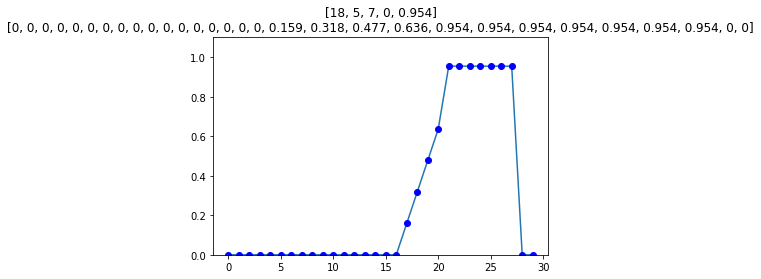

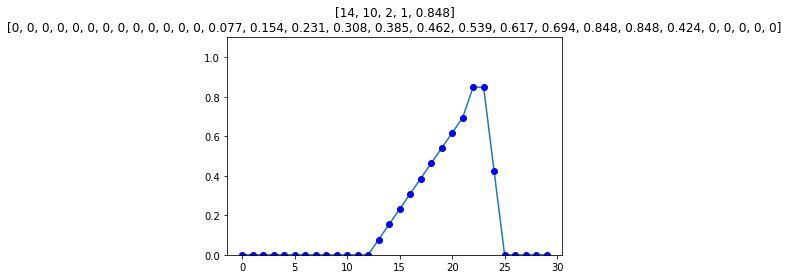

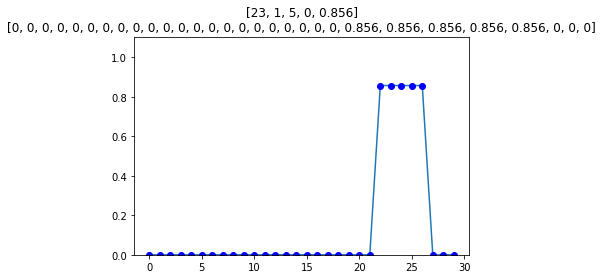

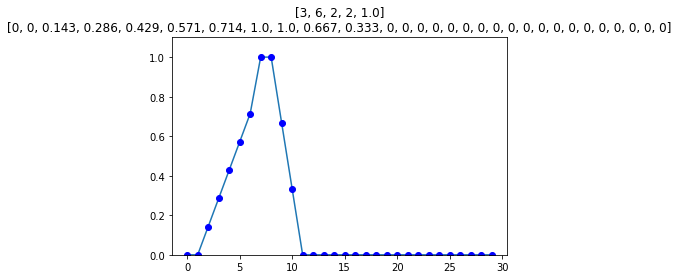

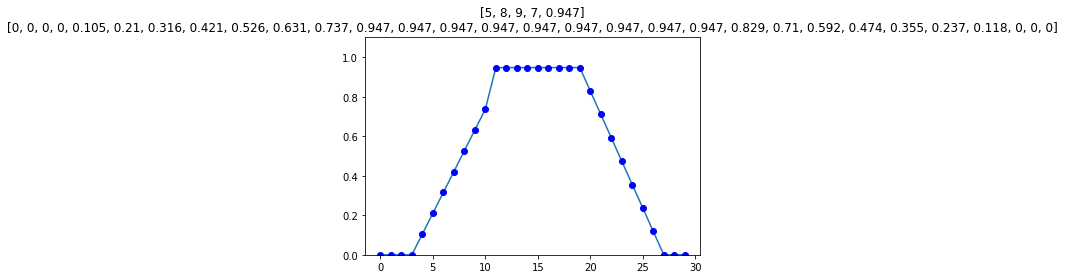

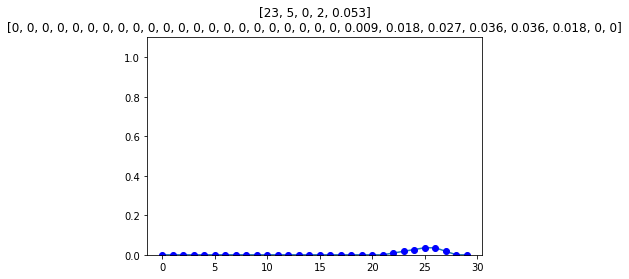

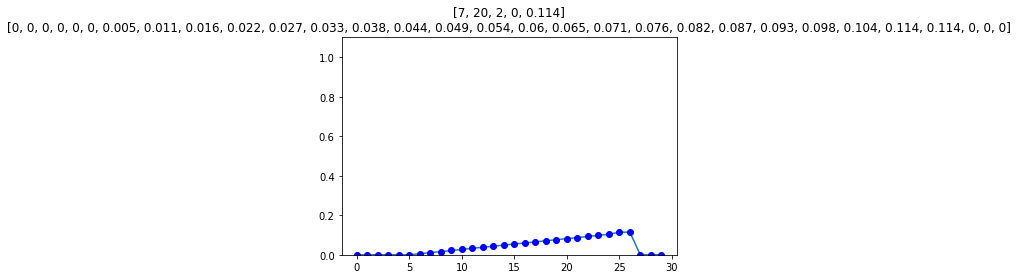

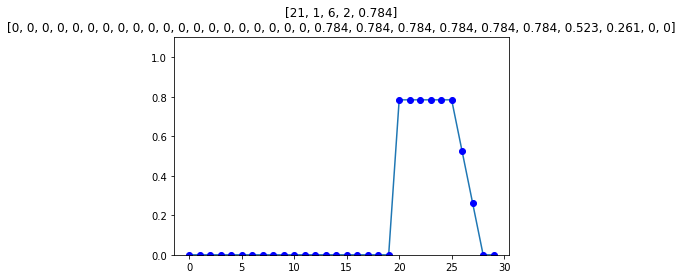

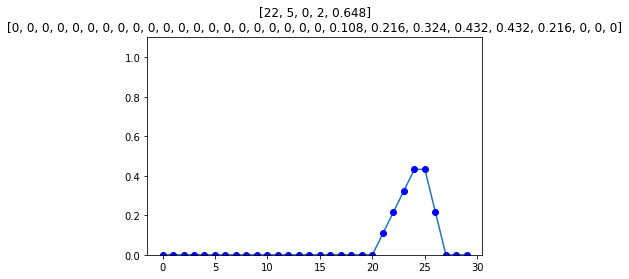

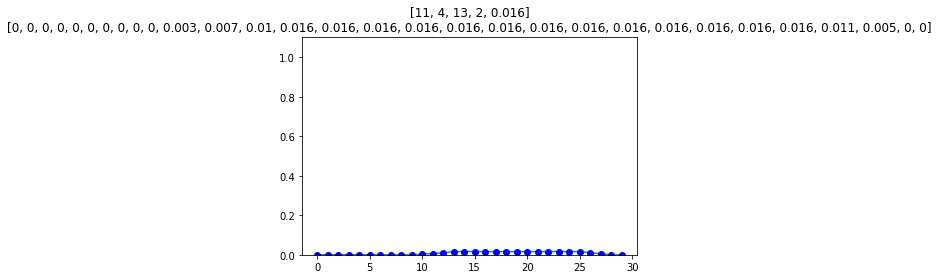

In [51]:
for i in range(10):
    plt.figure()
    plt.plot(range(30), model.groups[0].females[i].swellingList)
    plt.plot(range(30), model.groups[0].females[i].swellingList, 'bo')
    plt.ylim([0,1.1])
    plt.title(str([round(g,3) for g in model.groups[0].females[i].genes]) + "\n" + str([round(s,3) for s in model.groups[0].females[i].swellingList]))
    

# Visualizing results of some sensitivity analyses

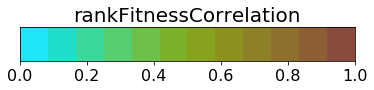

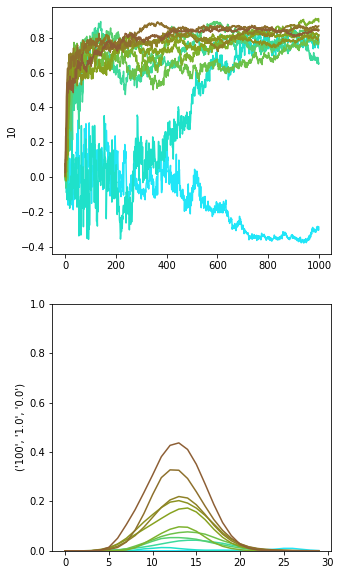

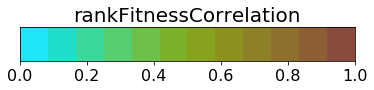

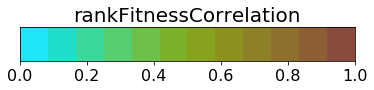

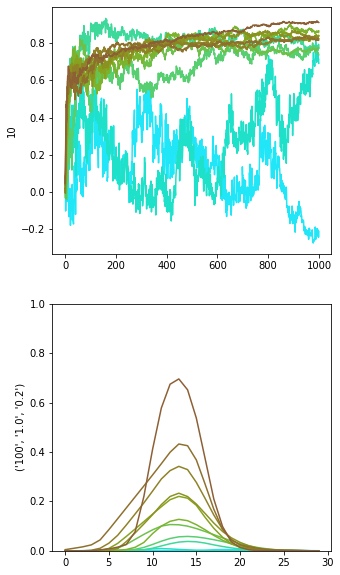

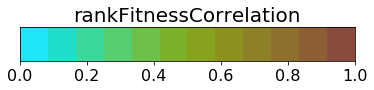

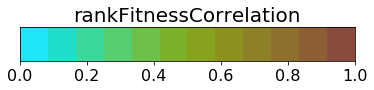

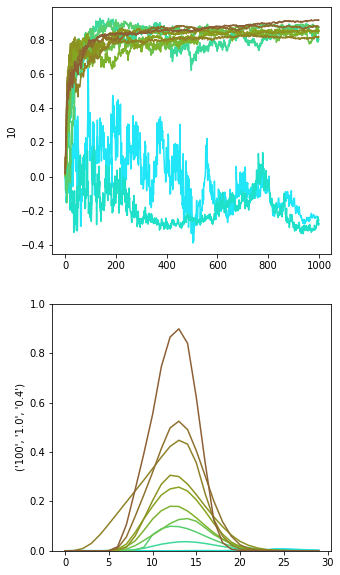

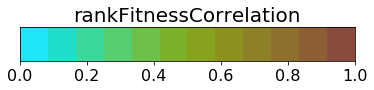

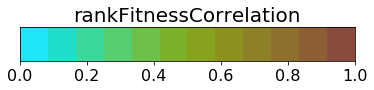

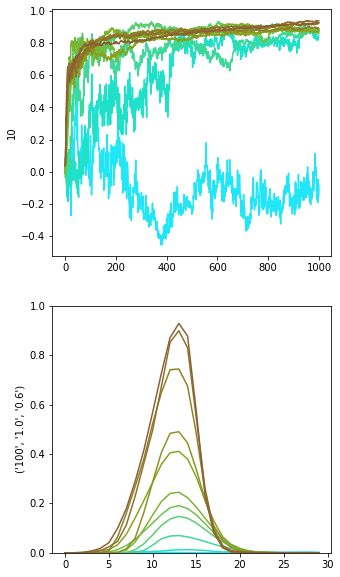

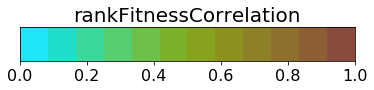

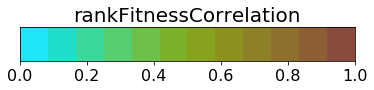

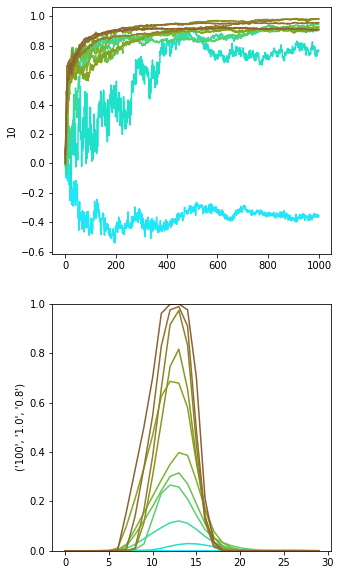

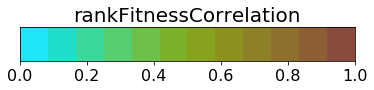

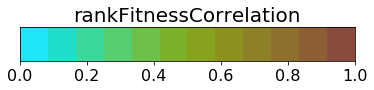

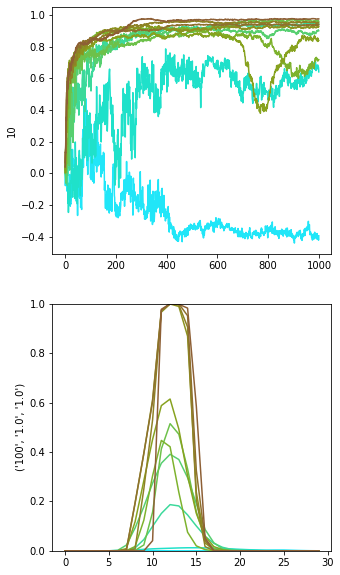

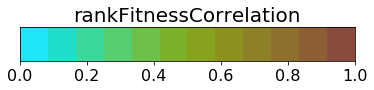

In [5]:
functionZero = pd.read_csv("modelDataSynchZero.csv").iloc[:,1:]
functionPoint2 = pd.read_csv("modelDataSynchPoint2.csv").iloc[:,1:]
functionPoint4 = pd.read_csv("modelDataSynchPoint4.csv").iloc[:,1:]
functionPoint6 = pd.read_csv("modelDataSynchPoint6.csv").iloc[:,1:]
functionPoint8 = pd.read_csv("modelDataSynchPoint8.csv").iloc[:,1:]
functionOne = pd.read_csv("modelDataSynchOne.csv").iloc[:,1:]

corralZero = pd.read_csv("swellingConceptionProbCorrelationsSynchZero.csv").iloc[:,1:].T
corralPoint2 = pd.read_csv("swellingConceptionProbCorrelationsSynchPoint2.csv").iloc[:,1:].T
corralPoint4 = pd.read_csv("swellingConceptionProbCorrelationsSynchPoint4.csv").iloc[:,1:].T
corralPoint6 = pd.read_csv("swellingConceptionProbCorrelationsSynchPoint6.csv").iloc[:,1:].T
corralPoint8 = pd.read_csv("swellingConceptionProbCorrelationsSynchPoint8.csv").iloc[:,1:].T
corralOne = pd.read_csv("swellingConceptionProbCorrelationsSynchOne.csv").iloc[:,1:].T

functions = [functionZero, functionPoint2, functionPoint4, functionPoint6, functionPoint8, functionOne]
correls = [corralZero, corralPoint2, corralPoint4, corralPoint6, corralPoint8, corralOne]
palette = np.flip(sns.color_palette("viridis",100))[range(0,78,7)]


for k,j in zip(functions,correls):
    plt.figure()
    ax = plt.imshow([palette], extent=[0, 1.0, 0, 0.1])
    plt.tick_params(labelsize=16)
    plt.yticks([], [])
    plt.title('rankFitnessCorrelation', fontsize = 20)

    fig, axes = plt.subplots(2,1,figsize=(5,10))
    [sns.lineplot(range(nGenerations), j[i], color=palette[i], ax=axes[0]) for i in range(11)]
    [sns.lineplot(range(30), k.iloc[3:33, i], color=palette[i], ax=axes[1]) for i in range(11)]
    plt.ylim([0,1.0])

    plt.figure()
    ax = plt.imshow([palette], extent=[0, 1.0, 0, 0.1])
    plt.tick_params(labelsize=16)
    plt.yticks([], [])
    plt.title('rankFitnessCorrelation', fontsize = 20)


In [19]:
nDays = 60
nGenerations = 1
modelRuns = 0
swellingConceptionProbCorrelations = []
for popSize in [100]:
    nMales = popSize
    nFemales = popSize
    for rankCorVal in arange(0.0,1.01,0.1):
        rankFitnessCorrelation = rankCorVal
        for synchronyVal in [0.0]:
            synchrony = synchronyVal
            model = evolvingModel()
            dailyData = pd.DataFrame()
            swellingConceptionProbCorrelations.append([])
            model.evolve()
            modelRuns += 1
            print(modelRuns)

swellingConceptionProbCorrelationsSynchZero = swellingConceptionProbCorrelations
modelDataSynchZero = modelData

modelRuns = 0
swellingConceptionProbCorrelations = []
modelData = pd.DataFrame()
for rankCorVal in arange(0.0,1.01,0.1):
        rankFitnessCorrelation = rankCorVal
        for synchronyVal in [0.2]:
            synchrony = synchronyVal
            model = evolvingModel()
            dailyData = pd.DataFrame()
            swellingConceptionProbCorrelations.append([])
            model.evolve()
            modelRuns += 1
            print(modelRuns)
            
swellingConceptionProbCorrelationsSynchPoint2 = swellingConceptionProbCorrelations            
modelDataSynchPoint2 = modelData

modelRuns = 0
swellingConceptionProbCorrelations = []
modelData = pd.DataFrame()
for rankCorVal in arange(0.0,1.01,0.1):
        rankFitnessCorrelation = rankCorVal
        for synchronyVal in [0.4]:
            synchrony = synchronyVal
            model = evolvingModel()
            dailyData = pd.DataFrame()
            swellingConceptionProbCorrelations.append([])
            model.evolve()
            modelRuns += 1
            print(modelRuns)
            
swellingConceptionProbCorrelationsSynchPoint4 = swellingConceptionProbCorrelations            
modelDataSynchPoint4 = modelData

modelRuns = 0
swellingConceptionProbCorrelations = []
modelData = pd.DataFrame()
for rankCorVal in arange(0.0,1.01,0.1):
        rankFitnessCorrelation = rankCorVal
        for synchronyVal in [0.6]:
            synchrony = synchronyVal
            model = evolvingModel()
            dailyData = pd.DataFrame()
            swellingConceptionProbCorrelations.append([])
            model.evolve()
            modelRuns += 1
            print(modelRuns)
            
swellingConceptionProbCorrelationsSynchPoint6 = swellingConceptionProbCorrelations            
modelDataSynchPoint6 = modelData

modelRuns = 0
swellingConceptionProbCorrelations = []
modelData = pd.DataFrame()
for rankCorVal in arange(0.0,1.01,0.1):
        rankFitnessCorrelation = rankCorVal
        for synchronyVal in [0.8]:
            synchrony = synchronyVal
            model = evolvingModel()
            dailyData = pd.DataFrame()
            swellingConceptionProbCorrelations.append([])
            model.evolve()
            modelRuns += 1
            print(modelRuns)
            
swellingConceptionProbCorrelationsSynchPoint8 = swellingConceptionProbCorrelations            
modelDataSynchPoint8 = modelData

modelRuns = 0
swellingConceptionProbCorrelations = []
modelData = pd.DataFrame()
for rankCorVal in arange(0.0,1.01,0.1):
        rankFitnessCorrelation = rankCorVal
        for synchronyVal in [1.0]:
            synchrony = synchronyVal
            model = evolvingModel()
            dailyData = pd.DataFrame()
            swellingConceptionProbCorrelations.append([])
            model.evolve()
            modelRuns += 1
            print(modelRuns)
            
swellingConceptionProbCorrelationsSynchOne = swellingConceptionProbCorrelations            
modelDataSynchOne = modelData

#modelData.to_csv('modelData2.csv')


NameError: name 'model' is not defined

In [110]:
modelData4 = pd.read_csv('slopesModelData1000.csv')
modelData4 = modelData4.iloc[:,1:]

In [111]:
modelData4[modelData4.columns[modelData4.iloc[0]==1]]

,"('noSwelling', '15', '1.0', '0.0')","('noSwelling', '15', '1.0', '0.33')","('noSwelling', '15', '1.0', '0.66')","('noSwelling', '15', '1.0', '1.0')","('noSwelling', '50', '1.0', '0.0')","('noSwelling', '50', '1.0', '0.33')","('noSwelling', '50', '1.0', '0.66')","('noSwelling', '50', '1.0', '1.0')","('noSwelling', '100', '1.0', '0.0')","('noSwelling', '100', '1.0', '0.33')","('noSwelling', '100', '1.0', '0.66')","('noSwelling', '100', '1.0', '1.0')"
0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.00,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.000000,0.330000,0.660000,1.0,0.000000,0.330000,0.66,1.000000,0.000000,0.330000,0.660000,1.000000
2,15.000000,15.000000,15.000000,15.0,50.000000,50.000000,50.00,50.000000,100.000000,100.000000,100.000000,100.000000
3,0.002149,0.002530,0.002807,0.0,0.000000,0.002474,0.00,0.002692,0.000932,0.000234,0.000749,0.000704
4,0.004498,0.005076,0.001369,0.0,0.000000,0.005283,0.00,0.005420,0.001729,0.000487,0.001421,0.000682
...,...,...,...,...,...,...,...,...,...,...,...,...
89,0.000000,0.003969,0.000000,0.0,0.002050,0.005814,0.00,0.000748,0.004128,0.002898,0.004685,0.006219
90,0.000000,0.003788,0.000000,0.0,0.001774,0.004236,0.00,0.001103,0.003289,0.002692,0.004332,0.005480
91,0.000000,0.003608,0.000000,0.0,0.001603,0.002645,0.00,0.001458,0.002892,0.002483,0.004207,0.004451
92,0.000000,0.003427,0.000000,0.0,0.001436,0.001500,0.00,0.001815,0.002572,0.002277,0.004186,0.003935


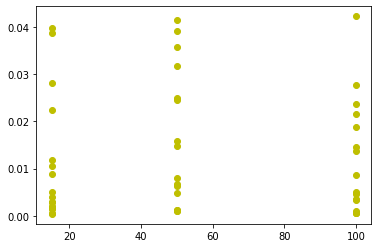

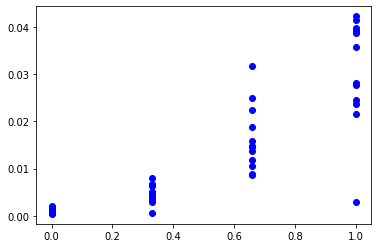

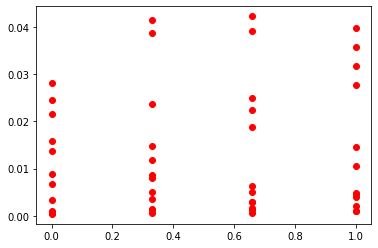

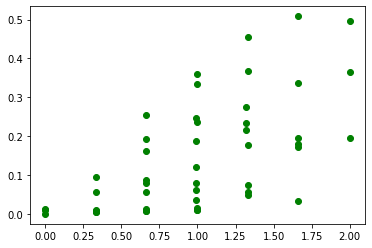

In [114]:
a = [plt.plot(modelData4.iloc[2,i], max(modelData4.iloc[3:33,i]), 'yo') for i in range(48)]
plt.figure()
b = [plt.plot(modelData4.iloc[0,i], max(modelData4.iloc[3:33,i]), 'bo') for i in range(48)]
plt.figure()
c = [plt.plot(modelData4.iloc[1,i], max(modelData4.iloc[3:33,i]), 'ro') for i in range(48)]
plt.figure()
d = [plt.plot(modelData4.iloc[0,i] + modelData4.iloc[1,i], sum(modelData4.iloc[3:33,i]), 'go')
 for i in range(len(modelData4.T))]


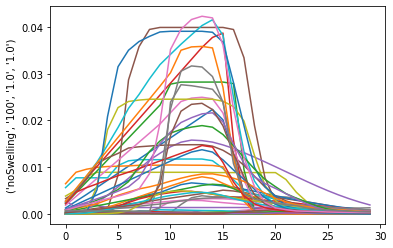

In [115]:
e= [[sns.lineplot(range(30), modelData4.iloc[3:33,i]) for i in range(48)]]

## Everything below this point is for testing code

In [ ]:
nMales = 25
nFemales = 25
nAgents = nFemales + nMales
model.nPairs = min(nMales, nFemales)
model.ranks = range(nMales)
nDays = 100
rankFitnessCorrelation = 0.66
nGenerations = 1
model = evolvingModel()
profiler = cProfile.Profile()
profiler.enable()
#model.groups[0].runModel()
model.evolve()
profiler.disable()
stats = pstats.Stats(profiler).sort_stats('tottime')
stats.print_stats()

In [ ]:
nDays = 60
nMales = 10
nFemales = 10
nAgents = nFemales + nMales
model.nPairs = min(nMales, nFemales)
model.ranks = range(nMales)
rankFitnessCorrelation = 1.0
cycleLength = 30
synchrony = 0.0
model = evolvingModel()

model.groups = [group(0)]

profiler = cProfile.Profile()
profiler.enable()

cycles = math.ceil(nDays / cycleLength)

IDs = [d for d in range(nFemales)] * nDays
cycleDays = [f.cycleDay-1
             for f
             in model.groups[0].females]

swellings = []
conceptionRisks = []

swellDictList = []

for i in range(nDays):
  swellings += [(f.swellingList  * nDays)[cycleDays[f.ID] + i] 
                for f 
                in model.groups[0].females]
  conceptionRisks += [(conceptionProbabilityList * nDays)[cycleDays[f.ID] + i]
                      for f
                      in model.groups[0].females]

fitnesses = model.groups[0].fitnessList


for day in range(nDays):
 swellDictList += [[[ID, swellings[day*nFemales + ID]
                     + model.groups[0].tieBreaker[day*nFemales + ID],conceptionRisks[day*nFemales + ID]]
                    for ID
                    in IDs[day*nFemales:day*nFemales+nFemales]]]


swellDictList = [sorted(swellDictList[i], key=lambda swelling: swelling[1])
                 for i
                 in range(nDays)]

swellDictList = [swellDictList[day][ID] + [ID] + [fitnesses[ID]] + [fitnesses[ID] * swellDictList[day][ID][2]]
                 for ID
                 in range(nFemales)
                 for day
                 in range(nDays)]

newSwellDictList = sorted(swellDictList, key=lambda swelling: swelling[0])

for lst in newSwellDictList:
    model.groups[0].females[lst[0]].reproductiveSuccess += lst[5]
    
profiler.disable()
stats = pstats.Stats(profiler).sort_stats('tottime')
stats.print_stats()

In [ ]:
model.

In [ ]:
model = evolvingModel()

profiler = cProfile.Profile()
profiler.enable()

model.groups[0].runModel()

profiler.disable()
stats = pstats.Stats(profiler).sort_stats('tottime')
stats.print_stats()